In [1]:
import sys
import os
import numpy as np

from PIL import Image
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection

from tokenExtraction import TokenReader
from tableExtraction import PretrainTableExtractionPipeline

# Give priority to the modules that are inside tableTransformer 
# and handles the conflict between tableTransformer/detr/datasets and hugging face datasets' library
sys.path.insert(1, os.getcwd() + '/tableTransformer/src')
sys.path.insert(2, os.getcwd() + '/tableTransformer/detr')
# This snipet is necessary for inference to work

from tableTransformer.src.inference import output_result

from dotenv import load_dotenv
load_dotenv() 


/home/martin/miniconda3/envs/tables-detr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
TABLE_DETECTION_MODEL = AutoModelForObjectDetection.from_pretrained(os.environ['TABLE_DETECTION_MODEL_PATH'], revision="no_timm")
TABLE_STRUCTURE_MODEL = TableTransformerForObjectDetection.from_pretrained(os.environ['TABLE_STRUCTURE_MODEL_PATH'])

In [3]:
table_extraction_pipeline = PretrainTableExtractionPipeline(
    det_device=os.environ['TABLE_DETECTION_DEVICE'], 
    str_device=os.environ['TABLE_STRUCTURE_DEVICE'], 
    det_model=TABLE_DETECTION_MODEL,
    str_model=TABLE_STRUCTURE_MODEL
)

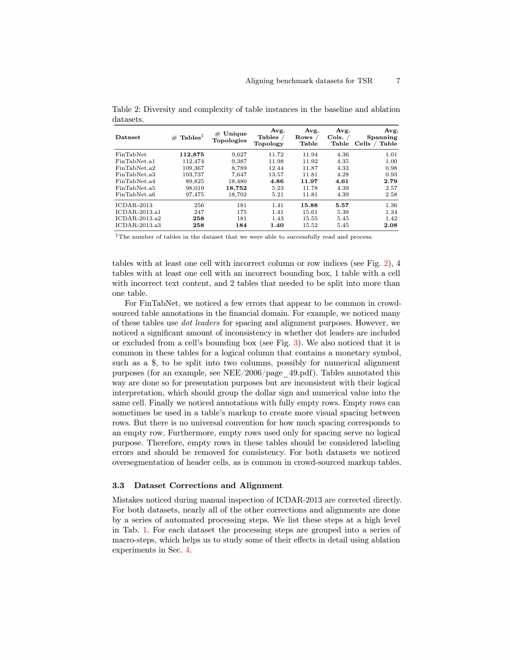

In [4]:
img_file = f'2303_00716.jpg'

image = Image.open(img_file).convert("RGB")
width, height = image.size

display(image.resize((int(0.4*width), (int(0.4*height)))))

`tokens` is expected to be a list of dictionaries containing a list of words and their bounding boxes in image coordinates. It is assumed to be sorted in reading order. The format for tokens is:  
```python
[
    {
        'bbox': [0.0, 0.0, 50.0, 50.0],
        'text': 'First'
        'span_num': 1,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    },
    {
        'bbox': [52.0, 0.0, 102.0, 50.0],
        'text': 'next'
        'span_num': 2,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    }
]
```

Multiple approaches can be tested:
- ocr the whole doc and pass the tokens to the pipline (this should work because the `extract` method re assign `tokens` with output of previous step in the pipline) 
- ocr the cropped tables and pass the tokens to the recognize function
- ocr every cell like in this tutorial: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb


I'm using EasyOCR http://www.jaided.ai/easyocr/documentation/   

Additional ressources: 
 
- Quickstart Tutorial: https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168
- Improve noisy image quality: https://github.com/microsoft/table-transformer/discussions/146
- Generate tokens for image and pdf: https://github.com/microsoft/table-transformer/issues/121



## OCR the whole document

In [5]:
token_reader = TokenReader(
    language=os.environ['READER_LANGUAGE'], 
    device=os.environ['READER_DEVICE']
)
readtext_args = {'low_text': 0.3}

tokens = token_reader.get_tokens(img_file, readtext_args)

Using CPU. Note: This module is much faster with a GPU.


This guy had a similar problem (tokens missing or inexact ponctuation), providing a lower `low_text` solved the issue: https://stackoverflow.com/questions/77738509/easyocr-does-not-recognize-this-number-in-an-image

This guy have a similar issue (an `7` not recognized, does not seem to appear in our case), here how he solved it: https://github.com/JaidedAI/EasyOCR/issues/254#issuecomment-1267379900 

### One step table extraction 

In [ ]:
args = type('Args', (object,), {
    'visualize': True, 
    'out_dir': 'outputs/one_step_extraction/',
    'verbose': False
} )

out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

extracted_tables = table_extraction_pipeline.extract(image, tokens=tokens, **out_options)

In [ ]:
for table_idx, extracted_table in enumerate(extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], img_file.replace('.jpg', f'_{table_idx}.jpg'))

It is okay, but the are some mistakes, for exemple a `,` that become `.,` and another that become `.` and there is a `4` that disapear   
*EDIT*: providing `low_text=0.3` to the reader solves this problem

## OCR the only the cropped tables

### Two Steps table extraction

In [ ]:
detection_out_options = {
    'out_objects': True,
    'out_crops': True
}
structure_out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

args = type('Args', (object,), {
    'visualize':True,
    'out_dir': 'outputs/two_steps_extraction/',
    'verbose': False
})

detected_tables = table_extraction_pipeline.detect(image, **detection_out_options)

for crop_idx, crop_table in enumerate(detected_tables['crops']): 
    crop_image = crop_table['image']
    crop_tokens = token_reader.get_tokens(np.array(crop_image), readtext_args)
    
    table_structure = table_extraction_pipeline.recognize(
        crop_image, 
        crop_tokens, 
        **out_options
    )

    for key, val in table_structure.items():
        output_result(key, val, args, crop_image, f'crop_{crop_idx}_{img_file}')

Having the same kind of problems than the previous method (not the exact same mistakes but inexact ponctuation and missing numbers)   
*EDIT*: providing `low_text=0.3` to the reader solves this problem

The big difference between one step and 2 steps extraction is the column repartition: with one step extraction the colmuns are wider and overlap more than in 2 step extraction.  
Also, you dont have to ocr the whole doc, which means faster result.